<a href="https://colab.research.google.com/github/NSR9/PythonForML-AI-Notes/blob/master/S6-Assignment/S6_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required Libraries**


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [21]:
# simple function to upload files from local drive

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

**Data Transformations**


* Here I've created a Class to transform Train & Test Data. And I'm using Compose function to chain in all the transform operations required in the form of list and then pass it on the different sets of data.
* I have already set the mean and the standard deviation to 0.1307 & 0.3081 
* 2 main parameters normalize(boolean) and rotate(default value = 0).


In [0]:
# # Transformations 

# class Transformations():

#   def __init__(self, normalize=True, rotate = 0):
#       self.normalize = normalize
#       self.rotate = rotate


#   # For Train Data
#   def train_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = []
#       transforms_list.append(transforms.ToTensor())
#       if self.normalize: 
#           transforms_list.append(transforms.Normalize((0.1307, ), (0.3081, )))
#       if self.rotate:
#           transforms_list.append(transforms.RandomRotation((-1*int(self.rotate), int(self.rotate)), fill=(1,)))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)


#   # For Test Data
#   def test_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = [transforms.ToTensor()]
#       if self.normalize:
#           transforms_list.append(transforms.Normalize((0.1307, ),(0.3081, )))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)



# mnist_data = Transformations(normalize = True, rotate = 5)    # set normalize = True
# train_trans = mnist_data.train_transforms(tensorToPIL = True)  # Rotation of Train Images
# test_trans = mnist_data.test_transforms(tensorToPIL = True)

In [0]:
# Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      #  transforms.ToPILImage()# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      #  transforms.ToPILImage()
                                       ])


In [0]:
# Split Test & Train Data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

**Dataloaders Arguments & Train/Test Dataloaders**

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 128):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

**Data Statistics**

torch.Size([128, 1, 28, 28])
torch.Size([128])


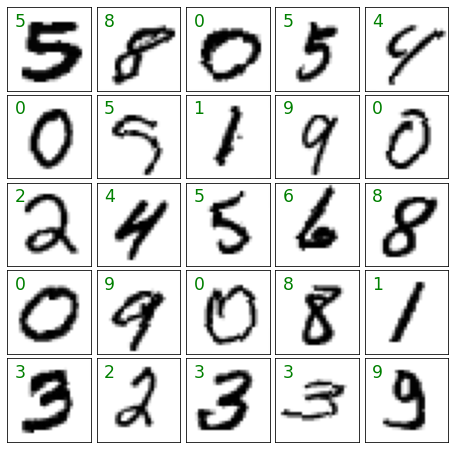

In [0]:

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape) # [64, 1, 28, 28]
print(labels.shape) # [64]


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


def display_25(images, labels):
  figmatrix = plt.figure(figsize=(8, 8))
  row, col = 5, 5 # set rows & columns = 5
  gs = gridspec.GridSpec(row, col)
  gs.update(wspace=0.005, hspace=0.05)

  for i in range(1, 26):
    plt.subplot(gs[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="xx-large")
  plt.show()

display_25(images[:25], labels[:25])



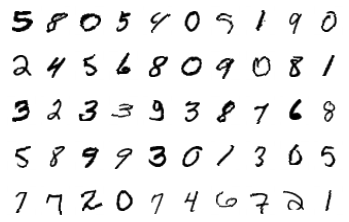

In [0]:
# Just curious at the orientation of these mnist images
figure = plt.figure()
num_of_images = 50
for i in range(1,num_of_images+1):
  plt.subplot(5,10, i)
  plt.axis('off')
  plt.imshow(images[i-1].numpy().squeeze(), cmap = 'gray_r')

In [0]:
# Main Model with Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(8)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      



**Model Summary**

In [30]:
# BN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))


  # def plot(graph = None):
  #   super(Test_Train,self).__init__()

  #   if graph == 'Accuracy':
  #     plt.figure(figsize=(15, 10))
  #     ax = plt.subplot(111)
  #     ax.plot(acc1)
  #     ax.plot(acc2)
  #     ax.plot(acc3)
  #     ax.plot(acc4)
  #     ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
  #     ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
  #     plt.savefig("Accuracyof4modelswithBN.png")
  #     plt.show()

    
  #   elif graph == 'Loss':
  #   plt.figure(figsize = (15,10))
  #   ax = plt.subplot(111)
  #   ax.plot(loss1)
  #   ax.plot(loss2)
  #   ax.plot(loss3)
  #   ax.plot(loss4)
  #   ax.set(title='Validation Losses of 4 Models', xlabel='Epoch', ylabel = 'Loss')
  #   ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
  #   plt.savefig('ValidationLossesBN.png')
  #   plt.show()







**Model 1**
#without L1 and L2 regularization with BN


In [0]:
def withoutL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with BN')

  model1= Test_Train()
  global loss1
  global acc1
  loss1 = model1.test_losses
  acc1 = model1.test_acc

  EPOCHS = 25 
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model1.train(model, device, train_loader, optimizer, epoch, scheduler)
      model1.test(model, device, test_loader,"model1.pt")



**Model 2**
#with L1 regularization with BN


In [0]:
def withL1_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#second model
  print('with L1 regularization with BN')

  model2 = Test_Train()
  global loss2
  global acc2
  loss2 = model2.test_losses
  acc2 = model2.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model2.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model2.test(model, device, test_loader,"model2.pt")

**Model 3**
#with L2 regularization with BN


In [0]:
def withL2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#third model
  print('with L2 regularization with BN')

  model3 = Test_Train()
  global loss3
  global acc3
  loss3 = model3.test_losses
  acc3 = model3.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model3.train(model, device, train_loader, optimizer, epoch, scheduler)
      model3.test(model, device, test_loader,"model3.pt")

**Model 4**
#with both L1 & L2 regularization with BN


In [0]:
def withL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#fourth  model
  print('with L1 & L2 regularization with BN')

  model4 = Test_Train()
  global loss4
  global acc4
  loss4 = model4.test_losses
  acc4 = model4.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model4.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model4.test(model, device, test_loader,"model4.pt")

In [38]:
modelTuple = iter(withoutL1_L2_BN(),
  withL1_BN())
 
print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

without L1 and L2 regularization with BN
EPOCH: 1


Loss=0.03586341068148613 Batch_id=468 Accuracy=87.74: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0559).  Saving model ...

Test set: Average loss: 0.0559, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.011489673517644405 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0559 --> 0.0459).  Saving model ...

Test set: Average loss: 0.0459, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.010065932758152485 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9841/10000 (98.41%)

EPOCH: 4


Loss=0.002664753934368491 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0459 --> 0.0394).  Saving model ...

Test set: Average loss: 0.0394, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.04616279527544975 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0394 --> 0.0343).  Saving model ...

Test set: Average loss: 0.0343, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.15417085587978363 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0343 --> 0.0331).  Saving model ...

Test set: Average loss: 0.0331, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.001089595491066575 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0331 --> 0.0255).  Saving model ...

Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.015016141347587109 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:59<00:00,  7.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0255 --> 0.0250).  Saving model ...

Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.13661475479602814 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.05599367618560791 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:54<00:00,  8.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0250 --> 0.0244).  Saving model ...

Test set: Average loss: 0.0244, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.07787617295980453 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.021708106622099876 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:55<00:00,  8.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0244 --> 0.0242).  Saving model ...

Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.015629621222615242 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0242 --> 0.0208).  Saving model ...

Test set: Average loss: 0.0208, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.011140272952616215 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0208 --> 0.0204).  Saving model ...

Test set: Average loss: 0.0204, Accuracy: 9947/10000 (99.47%)

EPOCH: 15


Loss=0.010993901640176773 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.00311625306494534 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0204 --> 0.0192).  Saving model ...

Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.01361276488751173 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0192 --> 0.0181).  Saving model ...

Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.02652389369904995 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:56<00:00,  8.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.0037471652030944824 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0181 --> 0.0174).  Saving model ...

Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.02195710502564907 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0174 --> 0.0170).  Saving model ...

Test set: Average loss: 0.0170, Accuracy: 9952/10000 (99.52%)

EPOCH: 21


Loss=0.013152227737009525 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0170 --> 0.0160).  Saving model ...

Test set: Average loss: 0.0160, Accuracy: 9950/10000 (99.50%)

EPOCH: 22


Loss=0.022793641313910484 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0160 --> 0.0153).  Saving model ...

Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

EPOCH: 23


Loss=0.013764266856014729 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9958/10000 (99.58%)

EPOCH: 24


Loss=0.014818101190030575 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0153 --> 0.0144).  Saving model ...

Test set: Average loss: 0.0144, Accuracy: 9954/10000 (99.54%)

EPOCH: 25


Loss=0.00044118985533714294 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0146, Accuracy: 9953/10000 (99.53%)



  0%|          | 0/469 [00:00<?, ?it/s]

with L1 regularization with BN
EPOCH: 1


Loss=0.09699196368455887 Batch_id=468 Accuracy=86.17: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0595).  Saving model ...

Test set: Average loss: 0.0595, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


Loss=0.038198426365852356 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0595 --> 0.0417).  Saving model ...

Test set: Average loss: 0.0417, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.06450289487838745 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0417 --> 0.0343).  Saving model ...

Test set: Average loss: 0.0343, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08233523368835449 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:56<00:00,  8.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.04230794310569763 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.08517030626535416 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0343 --> 0.0276).  Saving model ...

Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.031850628554821014 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.0763484537601471 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.06396568566560745 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0276 --> 0.0226).  Saving model ...

Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.018740274012088776 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.024278568103909492 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.014875891618430614 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0226 --> 0.0225).  Saving model ...

Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.024906441569328308 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0225 --> 0.0193).  Saving model ...

Test set: Average loss: 0.0193, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.02550942823290825 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.03771772235631943 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.09083709120750427 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0193 --> 0.0167).  Saving model ...

Test set: Average loss: 0.0167, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.01465665828436613 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.02094072848558426 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.015696849673986435 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.019282761961221695 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.013351171277463436 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.0244524497538805 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.016467489302158356 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0167 --> 0.0157).  Saving model ...

Test set: Average loss: 0.0157, Accuracy: 9954/10000 (99.54%)

EPOCH: 24


Loss=0.02509569749236107 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.013648292049765587 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Validation loss has  decreased (0.0157 --> 0.0155).  Saving model ...

Test set: Average loss: 0.0155, Accuracy: 9951/10000 (99.51%)



TypeError: ignored

In [36]:
modelTuple34 = iter(
  withL2_BN(), 
  withL1_L2_BN())
 
print(modelTuple34.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

with L2 regularization with BN
EPOCH: 1


Loss=0.09669537097215652 Batch_id=468 Accuracy=88.09: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0751).  Saving model ...

Test set: Average loss: 0.0751, Accuracy: 9751/10000 (97.51%)

EPOCH: 2


Loss=0.04724560305476189 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0751 --> 0.0441).  Saving model ...

Test set: Average loss: 0.0441, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.12047075480222702 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.030963433906435966 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.005929537583142519 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:56<00:00,  8.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0441 --> 0.0409).  Saving model ...

Test set: Average loss: 0.0409, Accuracy: 9865/10000 (98.65%)

EPOCH: 6


Loss=0.0507817305624485 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0409 --> 0.0320).  Saving model ...

Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.011067536659538746 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.062061768025159836 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0320 --> 0.0309).  Saving model ...

Test set: Average loss: 0.0309, Accuracy: 9898/10000 (98.98%)

EPOCH: 9


Loss=0.019060714170336723 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0309 --> 0.0291).  Saving model ...

Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.12706822156906128 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0291 --> 0.0234).  Saving model ...

Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.10390574485063553 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.013436567038297653 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0234 --> 0.0196).  Saving model ...

Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.009733953513205051 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.028737174347043037 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.004874399397522211 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.0021168948151171207 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.006645641755312681 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.010833561420440674 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.0014584739692509174 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0196 --> 0.0184).  Saving model ...

Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.03090055100619793 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.0073636192828416824 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.015109610743820667 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.0038936727214604616 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0184 --> 0.0172).  Saving model ...

Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.023013515397906303 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.013306963257491589 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

with L1 & L2 regularization with BN
EPOCH: 1


Loss=0.09187652915716171 Batch_id=468 Accuracy=86.57: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0555).  Saving model ...

Test set: Average loss: 0.0555, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.055815450847148895 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0555 --> 0.0436).  Saving model ...

Test set: Average loss: 0.0436, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.06488470733165741 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0436 --> 0.0346).  Saving model ...

Test set: Average loss: 0.0346, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.07045694440603256 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0346 --> 0.0292).  Saving model ...

Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.05168447643518448 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.015392144210636616 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.08473674952983856 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0292 --> 0.0291).  Saving model ...

Test set: Average loss: 0.0291, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.015866652131080627 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0291 --> 0.0269).  Saving model ...

Test set: Average loss: 0.0269, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.028463836759328842 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.06910370290279388 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0269 --> 0.0224).  Saving model ...

Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.01263010036200285 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.029146146029233932 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.02276594750583172 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.01420714519917965 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0224 --> 0.0209).  Saving model ...

Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.035875868052244186 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0209 --> 0.0194).  Saving model ...

Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.045719027519226074 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Loss=0.014477573335170746 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.04361123591661453 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.038214512169361115 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 20


Loss=0.013086006045341492 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0194 --> 0.0166).  Saving model ...

Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.028668813407421112 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:54<00:00,  8.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.012678897008299828 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0166 --> 0.0162).  Saving model ...

Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


Loss=0.039635926485061646 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:56<00:00,  8.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0162 --> 0.0160).  Saving model ...

Test set: Average loss: 0.0160, Accuracy: 9951/10000 (99.51%)

EPOCH: 24


Loss=0.016767408698797226 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)

EPOCH: 25


Loss=0.02624102681875229 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]



Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)



TypeError: ignored

In [0]:
import matplotlib.pyplot as plt


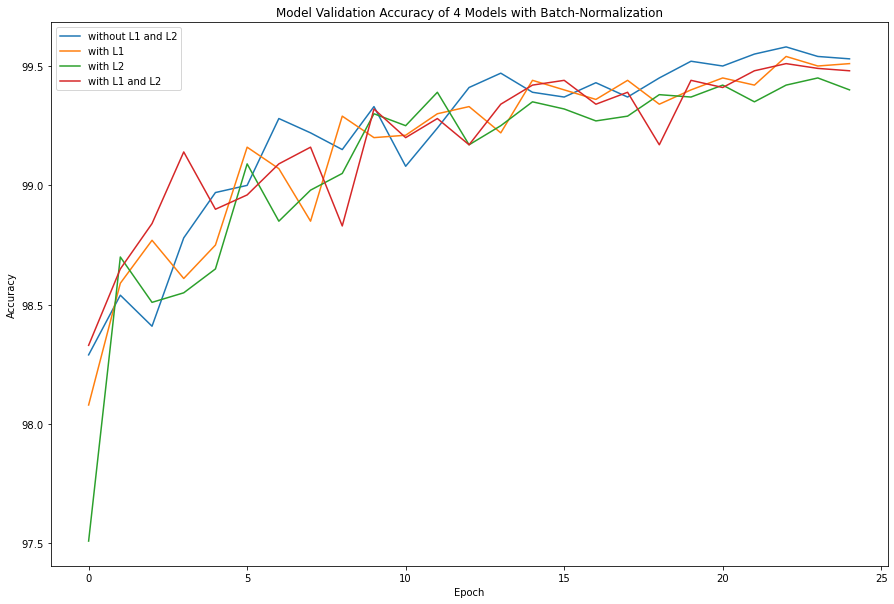

In [40]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1)
    ax.plot(acc2)
    ax.plot(acc3)
    ax.plot(acc4)
    ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithBN.png")
    plt.show()


b = accuracy_plot()
b

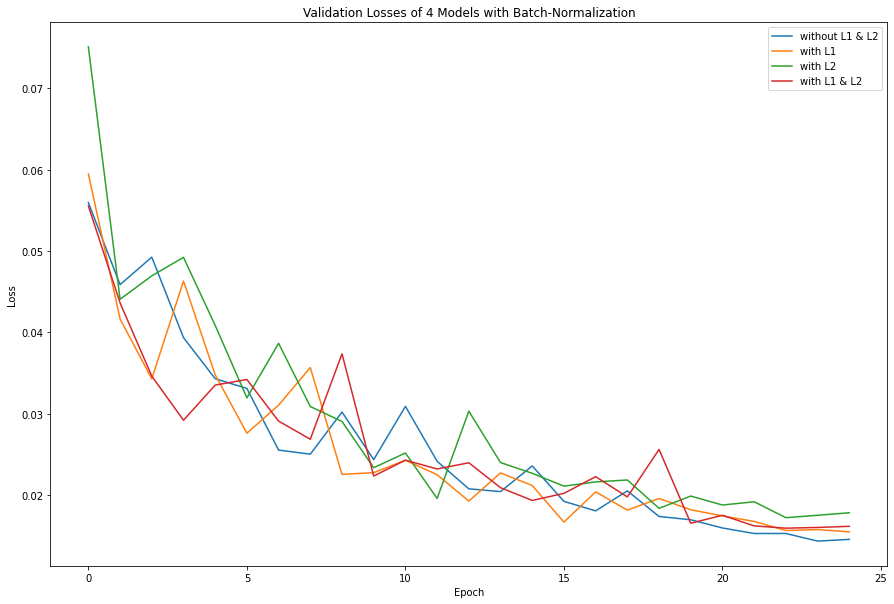

In [41]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss1)
    ax.plot(loss2)
    ax.plot(loss3)
    ax.plot(loss4)
    ax.set(title='Validation Losses of 4 Models with Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesBN.png')
    plt.show()

c = loss_plot()
c

In [0]:
# Misclassified Images

from google.colab import files
def misclassifiedOnes(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(128):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="Black")
          if count==25:
            break
      plt.savefig(filename)
  files.download(filename)

   


Misclassifed Images from Model1
******************************


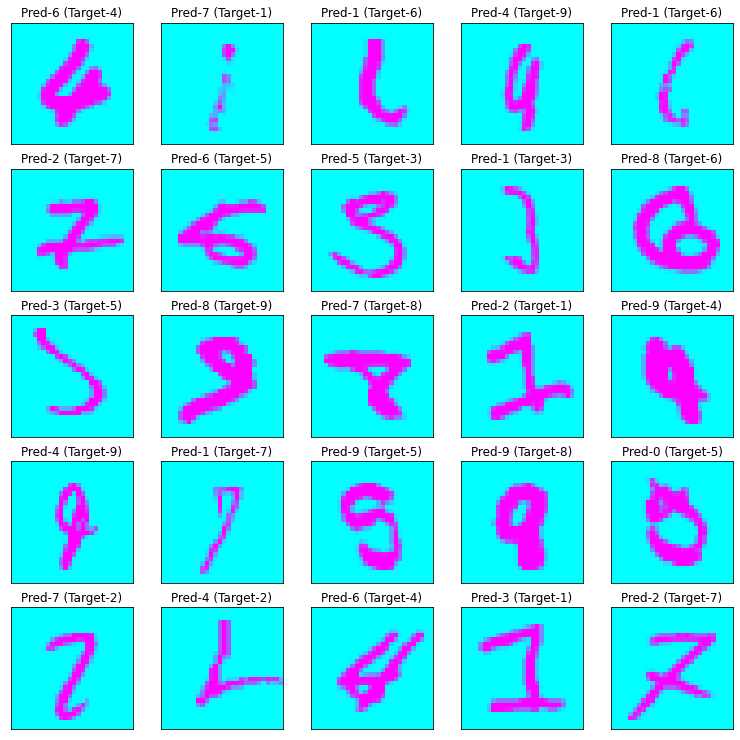

In [43]:
print('Misclassifed Images from Model1')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnes(model,'withoutL1_L2_BN.png')
# save_image()

Misclassifed Images from Model2
******************************


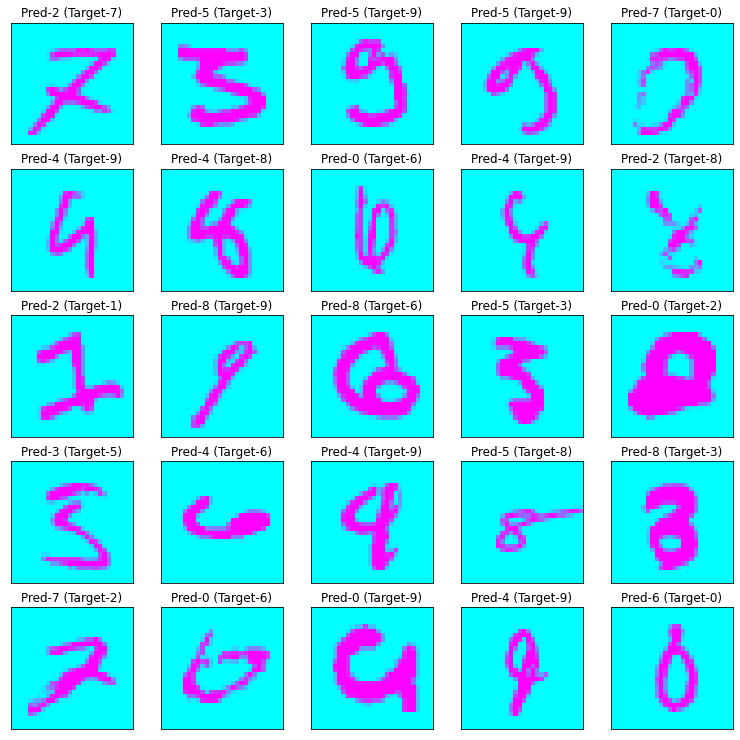

In [44]:
print('Misclassifed Images from Model2')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnes(model,'withL1_BN.png')

Misclassifed Images from Model3
******************************


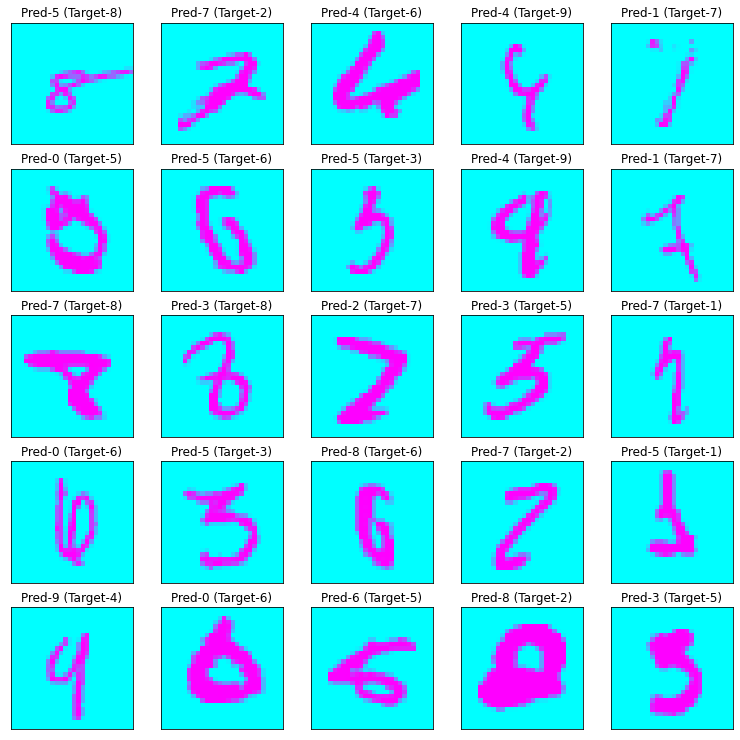

In [45]:
print('Misclassifed Images from Model3')
print('*'*30)
model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnes(model,'withL2_BN.png')

Misclassifed Images from Model4
******************************


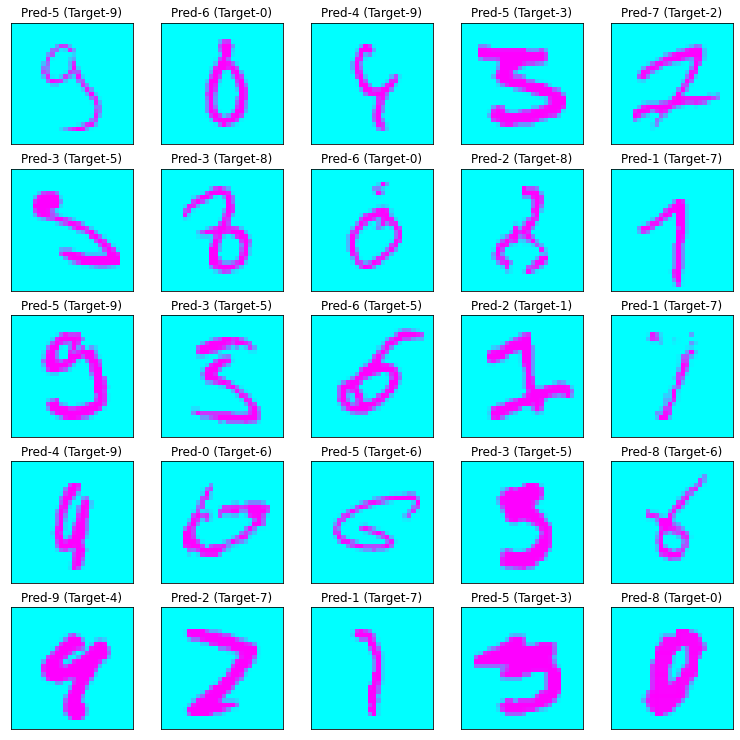

In [46]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withL1_L2_BN.png')

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 64):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

In [0]:
# Main Model with Ghost Batch Normalization
# use diff batch size for GBN

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          GhostBatchNorm(8,2)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(10,2)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      


# Ghost Batch Normalization

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0) # fill_() helps you filling up the tensor with a particular data
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))
    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




In [62]:
# GBN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelGBN = Net().to(device)
summary(modelGBN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
   GhostBatchNorm-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Model 5

def withoutL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with GBN')
#without L1 and L2 regularization with GBN

  model5= Test_Train()
  global loss5
  global acc5
  loss5 = model5.test_losses
  acc5 = model5.test_acc

  EPOCHS = 25  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model5.train(model, device, train_loader, optimizer, epoch, scheduler)
      model5.test(model, device, test_loader,"model5.pt")



In [0]:
# Model 6

def withL1_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#sixth model
  print('with L1 regularization with GBN')
#with L1 regularization with BN
  model6 = Test_Train()
  global loss6
  global acc6
  loss6 = model6.test_losses
  acc6 = model6.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model6.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model6.test(model, device, test_loader,"model6.pt")

In [0]:

def withL2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#seventh model
  print('with L2 regularization with GBN')
#with L2 regularization 
  model7 = Test_Train()
  global loss7
  global acc7
  loss7 = model7.test_losses
  acc7 = model7.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model7.train(model, device, train_loader, optimizer, epoch, scheduler)
      model7.test(model, device, test_loader,"model7.pt")

In [0]:


def withL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#eighth  model
  print('with L1 & L2 regularization with GBN')
#with both L1 & L2 regularization with BN
  model8 = Test_Train()
  global loss8
  global acc8
  loss8 = model8.test_losses
  acc8 = model8.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model8.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model8.test(model, device, test_loader,"model8.pt")

**Run all 4 models using an iterator**

In [0]:
GBNmodelTuple5_6 = iter(withoutL1_L2_GBN(),
  withL1_GBN())

# But one problem we've split the this into two model5 & model6, model7 & model8

print(GBNmodelTuple.__next__())

  0%|          | 0/938 [00:00<?, ?it/s]

without L1 and L2 regularization with GBN
EPOCH: 1


Loss=0.014615434221923351 Batch_id=937 Accuracy=91.09: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0510).  Saving model ...

Test set: Average loss: 0.0510, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.048899389803409576 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0510 --> 0.0365).  Saving model ...

Test set: Average loss: 0.0365, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.025869889184832573 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0365 --> 0.0351).  Saving model ...

Test set: Average loss: 0.0351, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.03660464286804199 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [01:00<00:00, 15.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0351 --> 0.0337).  Saving model ...

Test set: Average loss: 0.0337, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.009977909736335278 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9866/10000 (98.66%)

EPOCH: 6


Loss=0.1665031909942627 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0337 --> 0.0320).  Saving model ...

Test set: Average loss: 0.0320, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.009972808882594109 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [01:00<00:00, 15.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0320 --> 0.0287).  Saving model ...

Test set: Average loss: 0.0287, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.008403902873396873 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:01<00:00, 15.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9887/10000 (98.87%)

EPOCH: 9


Loss=0.014472431503236294 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [01:00<00:00, 15.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.0031354620587080717 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:00<00:00, 15.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.027203882113099098 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0287 --> 0.0256).  Saving model ...

Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.0005750635173171759 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:00<00:00, 15.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0256 --> 0.0252).  Saving model ...

Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.0019432066474109888 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0252 --> 0.0212).  Saving model ...

Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.0008555082604289055 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:00<00:00, 15.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.024496305733919144 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:00<00:00, 15.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.01067571435123682 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:01<00:00, 15.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.006286247633397579 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:00<00:00, 15.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.012010193429887295 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0212 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.005689829587936401 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.031758327037096024 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0181).  Saving model ...

Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)

EPOCH: 21


Loss=0.025778666138648987 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.009756982326507568 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [01:00<00:00, 15.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0181 --> 0.0174).  Saving model ...

Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


Loss=0.07381846010684967 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [01:00<00:00, 15.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0174 --> 0.0157).  Saving model ...

Test set: Average loss: 0.0157, Accuracy: 9953/10000 (99.53%)

EPOCH: 24


Loss=0.00029272865504026413 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [01:00<00:00, 15.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)

EPOCH: 25


Loss=0.0018261646619066596 Batch_id=937 Accuracy=99.57: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9952/10000 (99.52%)

with L1 regularization with GBN
EPOCH: 1


Loss=0.013643257319927216 Batch_id=937 Accuracy=91.31: 100%|██████████| 938/938 [01:02<00:00, 15.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0510).  Saving model ...

Test set: Average loss: 0.0510, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.04365301877260208 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [01:02<00:00, 14.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0510 --> 0.0478).  Saving model ...

Test set: Average loss: 0.0478, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.012958753854036331 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [01:02<00:00, 14.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0478 --> 0.0405).  Saving model ...

Test set: Average loss: 0.0405, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.015350637026131153 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [01:02<00:00, 14.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.03150210529565811 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9865/10000 (98.65%)

EPOCH: 6


Loss=0.037531524896621704 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0405 --> 0.0356).  Saving model ...

Test set: Average loss: 0.0356, Accuracy: 9887/10000 (98.87%)

EPOCH: 7


Loss=0.1291341930627823 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0356 --> 0.0309).  Saving model ...

Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.01873900182545185 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [01:03<00:00, 14.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0309 --> 0.0285).  Saving model ...

Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.028406374156475067 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.026059474796056747 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9895/10000 (98.95%)

EPOCH: 11


Loss=0.026608943939208984 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:02<00:00, 14.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0285 --> 0.0266).  Saving model ...

Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.0674007311463356 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0266 --> 0.0262).  Saving model ...

Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.02117053046822548 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0262 --> 0.0231).  Saving model ...

Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.02463555335998535 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.05901239439845085 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0231 --> 0.0230).  Saving model ...

Test set: Average loss: 0.0230, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.05330920219421387 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:07<00:00, 13.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0230 --> 0.0200).  Saving model ...

Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.02319304458796978 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:02<00:00, 14.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.03490353003144264 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:02<00:00, 15.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.018584847450256348 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:02<00:00, 15.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0200 --> 0.0180).  Saving model ...

Test set: Average loss: 0.0180, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.01721377857029438 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.021326735615730286 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0180 --> 0.0177).  Saving model ...

Test set: Average loss: 0.0177, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.020007597282528877 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0177 --> 0.0176).  Saving model ...

Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Loss=0.01939580962061882 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0176 --> 0.0174).  Saving model ...

Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)

EPOCH: 24


Loss=0.020311638712882996 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [01:02<00:00, 15.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.025922302156686783 Batch_id=937 Accuracy=99.56: 100%|██████████| 938/938 [01:02<00:00, 14.92it/s]


Validation loss has  decreased (0.0174 --> 0.0172).  Saving model ...

Test set: Average loss: 0.0172, Accuracy: 9952/10000 (99.52%)



TypeError: ignored

In [16]:
GBNmodel7_8  = iter(withL2_GBN(),
  withL1_L2_GBN())

print(GBNmodel7_8.__next__())


Loss=0.0009838773403316736 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.0014011008897796273 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0220 --> 0.0171).  Saving model ...

Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.17527270317077637 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.010237577371299267 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:04<00:00, 14.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.00038877272163517773 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.02939634956419468 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:59<00:00, 15.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0171 --> 0.0164).  Saving model ...

Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.005432561505585909 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [01:00<00:00, 15.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0164 --> 0.0149).  Saving model ...

Test set: Average loss: 0.0149, Accuracy: 9957/10000 (99.57%)

EPOCH: 23


Loss=0.015329529531300068 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:59<00:00, 15.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9954/10000 (99.54%)

EPOCH: 24


Loss=0.0016567460261285305 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:58<00:00, 16.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=6.794184446334839e-05 Batch_id=937 Accuracy=99.56: 100%|██████████| 938/938 [00:58<00:00, 15.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9950/10000 (99.50%)

with L1 & L2 regularization with GBN
EPOCH: 1


Loss=0.2449626624584198 Batch_id=937 Accuracy=91.67: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0920).  Saving model ...

Test set: Average loss: 0.0920, Accuracy: 9710/10000 (97.10%)

EPOCH: 2


Loss=0.06550835072994232 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [01:00<00:00, 15.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0920 --> 0.0489).  Saving model ...

Test set: Average loss: 0.0489, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.015096745453774929 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0489 --> 0.0406).  Saving model ...

Test set: Average loss: 0.0406, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.15417276322841644 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0406 --> 0.0370).  Saving model ...

Test set: Average loss: 0.0370, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.02845744788646698 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.07926106452941895 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0370 --> 0.0364).  Saving model ...

Test set: Average loss: 0.0364, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.020864034071564674 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0364 --> 0.0304).  Saving model ...

Test set: Average loss: 0.0304, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.03956499695777893 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0304 --> 0.0269).  Saving model ...

Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.019676636904478073 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.029460731893777847 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0269 --> 0.0260).  Saving model ...

Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.0901690199971199 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.02678053453564644 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.22652652859687805 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=0.04242783039808273 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9897/10000 (98.97%)

EPOCH: 15


Loss=0.031740859150886536 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 16


Loss=0.16054648160934448 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0260 --> 0.0245).  Saving model ...

Test set: Average loss: 0.0245, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.01370353251695633 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:00<00:00, 15.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.01559867337346077 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0245 --> 0.0236).  Saving model ...

Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.019904697313904762 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.18366236984729767 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0236 --> 0.0219).  Saving model ...

Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.05113961175084114 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:00<00:00, 15.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0219 --> 0.0203).  Saving model ...

Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.013663157820701599 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0203 --> 0.0179).  Saving model ...

Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.011863627471029758 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [01:01<00:00, 15.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0179 --> 0.0170).  Saving model ...

Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


Loss=0.04914916679263115 Batch_id=504 Accuracy=99.48:  54%|█████▎    | 503/938 [00:32<00:28, 15.40it/s]

Buffered data was truncated after reaching the output size limit.

  0%|          | 0/938 [00:00<?, ?it/s]

with L2 regularization with GBN
EPOCH: 1


Loss=0.019696684554219246 Batch_id=937 Accuracy=91.83: 100%|██████████| 938/938 [01:00<00:00, 15.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0520).  Saving model ...

Test set: Average loss: 0.0520, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.005169557873159647 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0520 --> 0.0382).  Saving model ...

Test set: Average loss: 0.0382, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.005454679951071739 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [01:02<00:00, 15.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0382 --> 0.0352).  Saving model ...

Test set: Average loss: 0.0352, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.03882018104195595 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0352 --> 0.0297).  Saving model ...

Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.03785992041230202 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9887/10000 (98.87%)

EPOCH: 6


Loss=0.004031127318739891 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0297 --> 0.0263).  Saving model ...

Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.17000234127044678 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.030361713841557503 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:01<00:00, 15.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0263 --> 0.0232).  Saving model ...

Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.06804340332746506 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.027036819607019424 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:01<00:00, 15.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0232 --> 0.0213).  Saving model ...

Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.06595995277166367 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.003389426739886403 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:00<00:00, 15.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0213 --> 0.0195).  Saving model ...

Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.004044158384203911 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.0021695513278245926 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0195 --> 0.0192).  Saving model ...

Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.020768266171216965 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:01<00:00, 15.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0192 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.0498046949505806 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:04<00:00, 14.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.14030586183071136 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:01<00:00, 15.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.0010426015360280871 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:01<00:00, 15.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0154).  Saving model ...

Test set: Average loss: 0.0154, Accuracy: 9953/10000 (99.53%)

EPOCH: 19


Loss=0.005823497660458088 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.006032977718859911 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9948/10000 (99.48%)

EPOCH: 21


Loss=0.007838169112801552 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


Loss=0.004238540772348642 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [01:00<00:00, 15.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Loss=0.05445856600999832 Batch_id=937 Accuracy=99.54: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0154 --> 0.0147).  Saving model ...

Test set: Average loss: 0.0147, Accuracy: 9953/10000 (99.53%)

EPOCH: 24


Loss=0.005540359299629927 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [01:00<00:00, 15.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0147 --> 0.0142).  Saving model ...

Test set: Average loss: 0.0142, Accuracy: 9955/10000 (99.55%)

EPOCH: 25


Loss=0.0009051203378476202 Batch_id=937 Accuracy=99.54: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0142 --> 0.0140).  Saving model ...

Test set: Average loss: 0.0140, Accuracy: 9957/10000 (99.57%)

with L1 & L2 regularization with GBN
EPOCH: 1


Loss=0.016284340992569923 Batch_id=937 Accuracy=91.91: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0540).  Saving model ...

Test set: Average loss: 0.0540, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.03164967894554138 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [01:02<00:00, 15.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0540 --> 0.0487).  Saving model ...

Test set: Average loss: 0.0487, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.020533941686153412 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0487 --> 0.0341).  Saving model ...

Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.016507945954799652 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.013881297782063484 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [01:02<00:00, 15.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9852/10000 (98.52%)

EPOCH: 6


Loss=0.01717294007539749 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [01:02<00:00, 15.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.1096084862947464 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0341 --> 0.0334).  Saving model ...

Test set: Average loss: 0.0334, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.019995084032416344 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0334 --> 0.0318).  Saving model ...

Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.021053660660982132 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [01:01<00:00, 15.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0318 --> 0.0294).  Saving model ...

Test set: Average loss: 0.0294, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.038724109530448914 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:04<00:00, 14.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.06838501989841461 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0294 --> 0.0250).  Saving model ...

Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.02133031375706196 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.01909182220697403 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.015253319405019283 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:01<00:00, 15.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9910/10000 (99.10%)

EPOCH: 15


Loss=0.01511801965534687 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0250 --> 0.0243).  Saving model ...

Test set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.0342915877699852 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0243 --> 0.0219).  Saving model ...

Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.014446890912950039 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:02<00:00, 15.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.01965162344276905 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [01:01<00:00, 15.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0219 --> 0.0194).  Saving model ...

Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.08154761046171188 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:06<00:00, 14.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0194 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.012702187523245811 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.012702078558504581 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0167).  Saving model ...

Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.016707684844732285 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [01:01<00:00, 15.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.0121982516720891 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [01:01<00:00, 15.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0167 --> 0.0161).  Saving model ...

Test set: Average loss: 0.0161, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.01718127727508545 Batch_id=937 Accuracy=99.54: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0161 --> 0.0155).  Saving model ...

Test set: Average loss: 0.0155, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.012750176712870598 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Validation loss has  decreased (0.0155 --> 0.0155).  Saving model ...

Test set: Average loss: 0.0155, Accuracy: 9944/10000 (99.44%)



TypeError: ignored

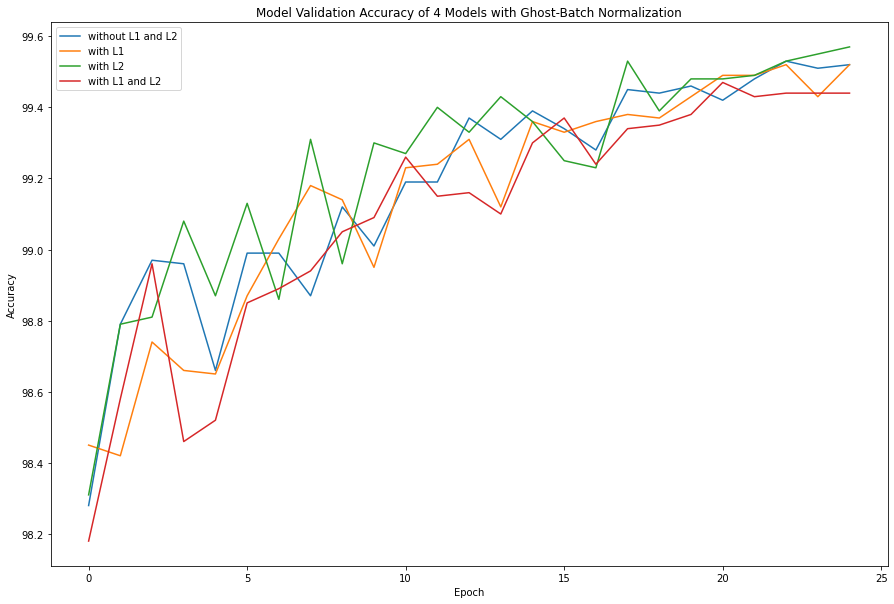

In [47]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc5)
    ax.plot(acc6)
    ax.plot(acc7)
    ax.plot(acc8)
    ax.set(title="Model Validation Accuracy of 4 Models with Ghost-Batch Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithGBN.png")
    plt.show()

d = accuracy_plot()
d



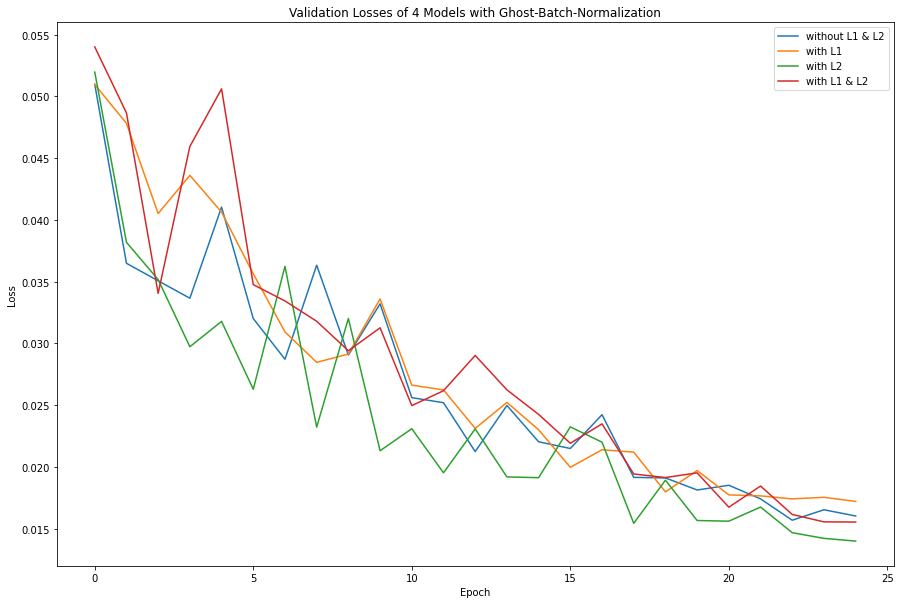

In [48]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss5)
    ax.plot(loss6)
    ax.plot(loss7)
    ax.plot(loss8)
    ax.set(title='Validation Losses of 4 Models with Ghost-Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesGBN.png')
    plt.show()

e = loss_plot()
e


Misclassifed Images from Model4
******************************


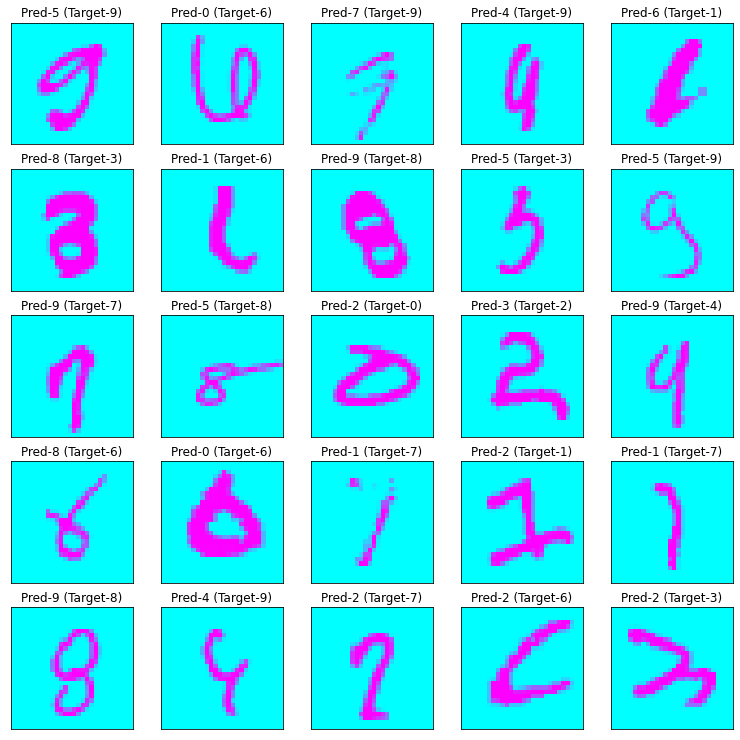

In [49]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withoutL1_L2_GBN.png')

In [58]:
print('Misclassifed Images from Model5')
print('*'*30)

model.load_state_dict(torch.load("model5.pt")) 
misclassifiedOnes(model,'withL1_GBN.png')

Misclassifed Images from Model5
******************************


RuntimeError: ignored

In [52]:
print('Misclassifed Images from Model7')
print('*'*30)

model.load_state_dict(torch.load("model7.pt")) 
misclassifiedOnes(model,'withL2_GBN.png')

Misclassifed Images from Model7
******************************


RuntimeError: ignored

In [0]:
print('Misclassifed Images from Model8')
print('*'*30)

model.load_state_dict(torch.load("model8.pt")) 
misclassifiedOnes(model,'withL1_L2_GBN.png')

**Validation Accuracy Plot for BN & GBN Models**



In [0]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1)
    ax.plot(acc2)
    ax.plot(acc3)
    ax.plot(acc4)
    ax.plot(acc5)
    ax.plot(acc6)
    ax.plot(acc7)
    ax.plot(acc8)
    ax.set(title="Validation Accuracy for BN & GBN Models", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2-BN', 'with L1-BN', 'with L2-BN', 'with L1 and L2-BN','without L1 and L2-GBN', 'with L1-GBN', 'with L2-GBN', 'with L1 and L2-GBN''], loc='best')
    plt.savefig("Accuracyof4modelswithBN-GBN.png")
    plt.show()

f = accuracy_plot()
f


**Validation Loss Plot for BN & GBN Models**


In [0]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1)
    ax.plot(acc2)
    ax.plot(acc3)
    ax.plot(acc4)
    ax.plot(acc5)
    ax.plot(acc6)
    ax.plot(acc7)
    ax.plot(acc8)
    ax.set(title="Validation Loss for BN & GBN Models", xlabel="Epoch", ylabel="Loss")
    ax.legend(['without L1 and L2-BN', 'with L1-BN', 'with L2-BN', 'with L1 and L2-BN','without L1 and L2-GBN', 'with L1-GBN', 'with L2-GBN', 'with L1 and L2-GBN''], loc='best')
    plt.savefig("Accuracyof4modelswithBN-GBN.png")
    plt.show()

g = accuracy_plot()
g
